# DBCV Experiments

### Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
import pandas as pd
from scipy.io import arff
from src.Evaluation.DBCV.dbcv import validity_index as DBCV
from src.Evaluation.DISCO.disco import disco_score as DISCO

### Load data

In [2]:
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN
from datasets.density_datasets import download_dataset
## load data
data_frame = pd.read_csv('datasets/synthetic_2_2.csv')
data = data_frame.copy()
# we need labels
labels = data['cluster'].astype(int).to_numpy()
# drop ground truth from dataframe
data = data.drop('cluster', axis=1)
features =  data.to_numpy()
X_moons_0, y_moons_0 = make_moons(n_samples=200, noise=0.0, random_state=42)

y_moons_0 = np.expand_dims(y_moons_0, axis=1)
moons_0 =  np.concatenate((X_moons_0, y_moons_0), axis=1)
moons_0_df = pd.DataFrame(data=moons_0, columns=['0','1','cluster'])

X_moons_1, y_moons_1 = make_moons(n_samples=200, noise=0.1, random_state=42)

y_moons_1 = np.expand_dims(y_moons_1, axis=1)
moons_1 =  np.concatenate((X_moons_1, y_moons_1), axis=1)
moons_1_df = pd.DataFrame(data=moons_1, columns=['0','1','cluster'])

X_moons_2, y_moons_2 = make_moons(n_samples=200, noise=0.15, random_state=42)
y_moons_2 = np.expand_dims(y_moons_2, axis=1)
moons_2 =  np.concatenate((X_moons_2, y_moons_2), axis=1)
moons_2_df = pd.DataFrame(data=moons_2, columns=['0','1','cluster'])


X_moons_3, y_moons_3 = make_moons(n_samples=200, noise=0.2, random_state=42)
y_moons_3 = np.expand_dims(y_moons_3, axis=1)
moons_3 =  np.concatenate((X_moons_3, y_moons_3), axis=1)
moons_3_df = pd.DataFrame(data=moons_3, columns=['0','1','cluster'])

def standardize(X, l, axis=None):
    std = np.std(X, axis=axis)
    mean = np.mean(X, axis=axis)
    if axis is not None:
        std = np.expand_dims(std, axis)
        mean = np.expand_dims(mean, axis)
    X = (X - mean) / std
    return X, l

X_cluto_4_8, l_cluto_4_8 = download_dataset('cluto-t4-8k')
l_cluto_4_8 = np.expand_dims(l_cluto_4_8, axis=1)
cluto_4_8 =  np.concatenate((X_cluto_4_8, l_cluto_4_8), axis=1)
names = [str(i) for i in range(X_cluto_4_8.shape[1])]+['cluster']
cluto_df_4_8 = pd.DataFrame(data=cluto_4_8, columns=names)

X_cluto_8_8, l_cluto_8_8 = download_dataset('cluto-t8-8k')
l_cluto_8_8 = np.expand_dims(l_cluto_8_8, axis=1)
cluto_8_8 =  np.concatenate((X_cluto_8_8, l_cluto_8_8), axis=1)
names = [str(i) for i in range(X_cluto_8_8.shape[1])]+['cluster']
cluto_df_8_8 = pd.DataFrame(data=cluto_8_8, columns=names)


X_cluto_4_8_std, l_cluto_4_8_std = download_dataset('cluto-t4-8k')
X_cluto_4_8_std, l_cluto_4_8_std = standardize(X_cluto_4_8_std, l_cluto_4_8_std)
l_cluto_4_8_std = np.expand_dims(l_cluto_4_8_std, axis=1)
cluto_4_8_std =  np.concatenate((X_cluto_4_8_std, l_cluto_4_8_std), axis=1)
names = [str(i) for i in range(X_cluto_4_8_std.shape[1])]+['cluster']
cluto_df_4_8_std = pd.DataFrame(data=cluto_4_8_std, columns=names)

X_cluto_8_8_std, l_cluto_8_8_std = download_dataset('cluto-t8-8k')
X_cluto_8_8_std, l_cluto_8_8_std = standardize(X_cluto_8_8_std, l_cluto_8_8_std)
l_cluto_8_8_std = np.expand_dims(l_cluto_8_8_std, axis=1)
cluto_8_8_std =  np.concatenate((X_cluto_8_8_std, l_cluto_8_8_std), axis=1)
names = [str(i) for i in range(X_cluto_8_8_std.shape[1])]+['cluster']
cluto_df_8_8_std = pd.DataFrame(data=cluto_8_8_std, columns=names)
#arff_file = arff.loadarff('datasets/cluto-t8-8k.arff')
#df = pd.DataFrame(arff_file[0])
#X_cluto=df[['x', 'y']].to_numpy()
#y_cluto = list(df['CLASS'])
#y_cluto_ = np.array([int(str(n)[-2]) if str(n)[-2] != 'e' else int(-1) for n in y_cluto])
#y_cluto = np.expand_dims(y_cluto_, axis=1)
#cluto =  np.concatenate((X_cluto, y_cluto), axis=1)
#cluto_df = pd.DataFrame(data=cluto, columns=['0','1','cluster'])


### DBCV Experiments

### Shuffle the dataset

In [3]:
def shuffle(data_frame):
    data = data_frame.to_numpy()
    features = data.shape[1]
    #shuffle dataset
    shuffled_data = data_frame.copy()
    shuffled_data = shuffled_data.sample(frac = 1)
    # we need labels
    shuffled_labels = shuffled_data['cluster'].astype(int).to_numpy()
    # first ten are features rest are groundtruth cluster and sensitive attribute
    shuffled_features = shuffled_data.iloc[:, : features-1].to_numpy()
    return shuffled_features, shuffled_labels

In [4]:
def plot(n, shuffle_report):
    x = range(n)
    report_series = pd.Series(shuffle_report)
    # Plot the figure.
    plt.figure(figsize=(12, 8))
    ax = report_series.plot(kind="bar")
    ax.set_title("DBCV over {}-Shuffle-Runs".format(n))
    ax.set_xlabel("Run")
    ax.set_ylabel("DBCV")

In [5]:
def shuffle_run(data_frame, i):
    shuffled_features, shuffled_labels = shuffle(data_frame)
    dbcv_shuffle = DBCV(shuffled_features, shuffled_labels,metric='sqeuclidean')
    return dbcv_shuffle

def shuffle_run_non_sq(data_frame, i):
    shuffled_features, shuffled_labels = shuffle(data_frame)
    dbcv_shuffle = DBCV(shuffled_features, shuffled_labels, metric='euclidean')
    return dbcv_shuffle

In [6]:
def plot_kde(shuffle_report, name="DBCV"):
    report_series = pd.DataFrame(shuffle_report,columns=[name])
    sns.displot(report_series, x=name, kind="kde")
    
    

In [7]:
from mpire import WorkerPool
def run_multiple_shuffle_runs_non_sq(n, data_frame):
    with WorkerPool(n_jobs=1, shared_objects=data_frame) as pool:
        shuffle_report = pool.map(shuffle_run_non_sq, range(n), progress_bar=True)
    return shuffle_report

def run_multiple_shuffle_runs(n, data_frame):
    with WorkerPool(n_jobs=1, shared_objects=data_frame) as pool:
        shuffle_report = pool.map(shuffle_run, range(n), progress_bar=True)
    return shuffle_report

In [8]:
def plot_shuffle_results(dbcv_list):
    plot_kde(dbcv_list)

In [9]:
def Disco_score(dataframe):
    feat = data.shape[1]
    labels = dataframe['cluster'].astype(int).to_numpy()
    # first ten are features rest are groundtruth cluster and sensitive attribute
    features = dataframe.iloc[:, : feat-1].to_numpy()
    return DISCO(features, labels)

In [50]:
print(cluto_df_4_8_std)
x, l =shuffle(cluto_df_4_8_std)
print(x.shape)

             0         1  cluster
0    -1.148488 -0.918037      0.0
1     1.476731  0.185712      2.0
2    -0.926252 -0.463841     -1.0
3     0.918788  0.174369      2.0
4     0.431734 -1.298406      5.0
...        ...       ...      ...
7995  1.393466  0.450318     -1.0
7996  1.754074  0.346830     -1.0
7997  0.204724 -0.651254      1.0
7998  0.005846  0.103575      1.0
7999 -0.532140 -0.408455      1.0

[8000 rows x 3 columns]
(8000, 2)


In [10]:
n = 100
#dbcv_list_dataset = run_multiple_shuffle_runs(n, data_frame)
#dbcv_list_cluto = run_multiple_shuffle_runs(n, cluto_df)

#dbcv_list_moons_0 = run_multiple_shuffle_runs(n, moons_0_df)
#disco_score_moons_0 = Disco_score(moons_0_df)
#dbcv_list_moons_1 = run_multiple_shuffle_runs(n, moons_1_df)
#disco_score_moons_1 = Disco_score(moons_1_df)
#dbcv_list_moons_2 = run_multiple_shuffle_runs(n, moons_2_df)
#disco_score_moons_2 = Disco_score(moons_2_df)
#dbcv_list_moons_3 = run_multiple_shuffle_runs(n, moons_3_df)
#disco_score_moons_3 = Disco_score(moons_3_df)

#dbcv_list_cluto_4_8 = run_multiple_shuffle_runs(n, cluto_df_4_8)
#dbcv_list_cluto_8_8 = run_multiple_shuffle_runs(n, cluto_df_8_8)
dbcv_list_cluto_4_8_std = run_multiple_shuffle_runs(n, cluto_df_4_8_std)
dbcv_list_cluto_8_8_std = run_multiple_shuffle_runs(n, cluto_df_8_8_std)

#dbcv_list_cluto_4_8_n = run_multiple_shuffle_runs_non_sq(n, cluto_df_4_8)
#dbcv_list_cluto_8_8_n = run_multiple_shuffle_runs_non_sq(n, cluto_df_8_8)
#dbcv_list_cluto_4_8_std_n = run_multiple_shuffle_runs_non_sq(n, cluto_df_4_8_std)
#dbcv_list_cluto_8_8_std_n = run_multiple_shuffle_runs_non_sq(n, cluto_df_8_8_std)
# dbcv_list_moons_0_kmeans = run_multiple_shuffle_runs(n, moons_0_kmeans_df)
# disco_score_moons_0_kmeans = Disco_score(moons_0_kmeans_df)
# dbcv_list_moons_1_kmeans = run_multiple_shuffle_runs(n, moons_1_kmeans_df)
# disco_score_moons_1_kmeans = Disco_score(moons_1_kmeans_df)
# dbcv_list_moons_2_kmeans = run_multiple_shuffle_runs(n, moons_2_kmeans_df)
# disco_score_moons_2_kmeans = Disco_score(moons_2_kmeans_df)
# dbcv_list_moons_3_kmeans = run_multiple_shuffle_runs(n, moons_3_kmeans_df)
# disco_score_moons_3_kmeans = Disco_score(moons_3_kmeans_df)
# 
# dbcv_list_moons_0_dbscan = run_multiple_shuffle_runs(n, moons_0_dbscan_df)
# disco_score_moons_0_dbscan = Disco_score(moons_0_dbscan_df)
# dbcv_list_moons_1_dbscan = run_multiple_shuffle_runs(n, moons_1_dbscan_df)
# disco_score_moons_1_dbscan = Disco_score(moons_1_dbscan_df)
# dbcv_list_moons_2_dbscan = run_multiple_shuffle_runs(n, moons_2_dbscan_df)
# disco_score_moons_2_dbscan = Disco_score(moons_2_dbscan_df)
# dbcv_list_moons_3_dbscan = run_multiple_shuffle_runs(n, moons_3_dbscan_df)
# disco_score_moons_3_dbscan = Disco_score(moons_3_dbscan_df)
# 
# dbcv_list_moons_0_hdbscan = run_multiple_shuffle_runs(n, moons_0_hdbscan_df)
# disco_score_moons_0_hdbscan = Disco_score(moons_0_hdbscan_df)
# dbcv_list_moons_1_hdbscan = run_multiple_shuffle_runs(n, moons_1_hdbscan_df)
# disco_score_moons_1_hdbscan = Disco_score(moons_1_dbscan_df)
# dbcv_list_moons_2_hdbscan = run_multiple_shuffle_runs(n, moons_2_hdbscan_df)
# disco_score_moons_2_hdbscan = Disco_score(moons_2_hdbscan_df)
# 
# dbcv_list_moons_3_hdbscan = run_multiple_shuffle_runs(n, moons_3_hdbscan_df)
# disco_score_moons_3_hdbscan = Disco_score(moons_3_hdbscan_df)

100%|██████████| 100/100 [01:20<00:00,  1.21it/s]


In [11]:
#sns.set_style('whitegrid')
#p = sns.displot(dbcv_results, x="DBCV", col="Dataset", height=2, color='midnightblue', aspect =2, kind='kde')
#p.fig.set_dpi(300)

#dbcv_moons_0 = pd.DataFrame(data = np.array(dbcv_list_moons_0), columns = ['DBCV'])
#dbcv_moons_1 = pd.DataFrame(data = np.array(dbcv_list_moons_1), columns = ['DBCV'])
#dbcv_moons_2 = pd.DataFrame(data = np.array(dbcv_list_moons_2), columns = ['DBCV'])
#dbcv_moons_3 = pd.DataFrame(data = np.array(dbcv_list_moons_3), columns = ['DBCV'])

#dbcv_cluto_8_4 = pd.DataFrame(data = np.array(dbcv_list_cluto_4_8), columns = ['DBCV'])
#dbcv_cluto_8_8 = pd.DataFrame(data = np.array(dbcv_list_cluto_8_8), columns = ['DBCV'])
dbcv_cluto_8_4_std = pd.DataFrame(data = np.array(dbcv_list_cluto_4_8_std), columns = ['DBCV'])
dbcv_cluto_8_8_std = pd.DataFrame(data = np.array(dbcv_list_cluto_8_8_std), columns = ['DBCV'])

#dbcv_cluto_8_4_n = pd.DataFrame(data = np.array(dbcv_list_cluto_4_8_n), columns = ['DBCV'])
#dbcv_cluto_8_8_n = pd.DataFrame(data = np.array(dbcv_list_cluto_8_8_n), columns = ['DBCV'])
#dbcv_cluto_8_4_std_n = pd.DataFrame(data = np.array(dbcv_list_cluto_4_8_std_n), columns = ['DBCV'])
#dbcv_cluto_8_8_std_n = pd.DataFrame(data = np.array(dbcv_list_cluto_8_8_std_n), columns = ['DBCV'])
#dbcv_moons_0_kmeans = pd.DataFrame(data = np.array(dbcv_list_moons_0_kmeans), columns = ['DBCV'])
#dbcv_moons_1_kmeans = pd.DataFrame(data = np.array(dbcv_list_moons_1_kmeans), columns = ['DBCV'])
#dbcv_moons_2_kmeans = pd.DataFrame(data = np.array(dbcv_list_moons_2_kmeans), columns = ['DBCV'])
#dbcv_moons_3_kmeans = pd.DataFrame(data = np.array(dbcv_list_moons_3_kmeans), columns = ['DBCV'])

#dbcv_moons_0_dbscan = pd.DataFrame(data = np.array(dbcv_list_moons_0_dbscan), columns = ['DBCV'])
#dbcv_moons_1_dbscan = pd.DataFrame(data = np.array(dbcv_list_moons_1_dbscan), columns = ['DBCV'])
#dbcv_moons_2_dbscan = pd.DataFrame(data = np.array(dbcv_list_moons_2_dbscan), columns = ['DBCV'])
#dbcv_moons_3_dbscan = pd.DataFrame(data = np.array(dbcv_list_moons_3_dbscan), columns = ['DBCV'])

#dbcv_moons_0_hdbscan = pd.DataFrame(data = np.array(dbcv_list_moons_0_hdbscan), columns = ['DBCV'])
#dbcv_moons_1_hdbscan = pd.DataFrame(data = np.array(dbcv_list_moons_1_hdbscan), columns = ['DBCV'])
#dbcv_moons_2_hdbscan = pd.DataFrame(data = np.array(dbcv_list_moons_2_hdbscan), columns = ['DBCV'])
#dbcv_moons_3_hdbscan = pd.DataFrame(data = np.array(dbcv_list_moons_3_hdbscan), columns = ['DBCV'])

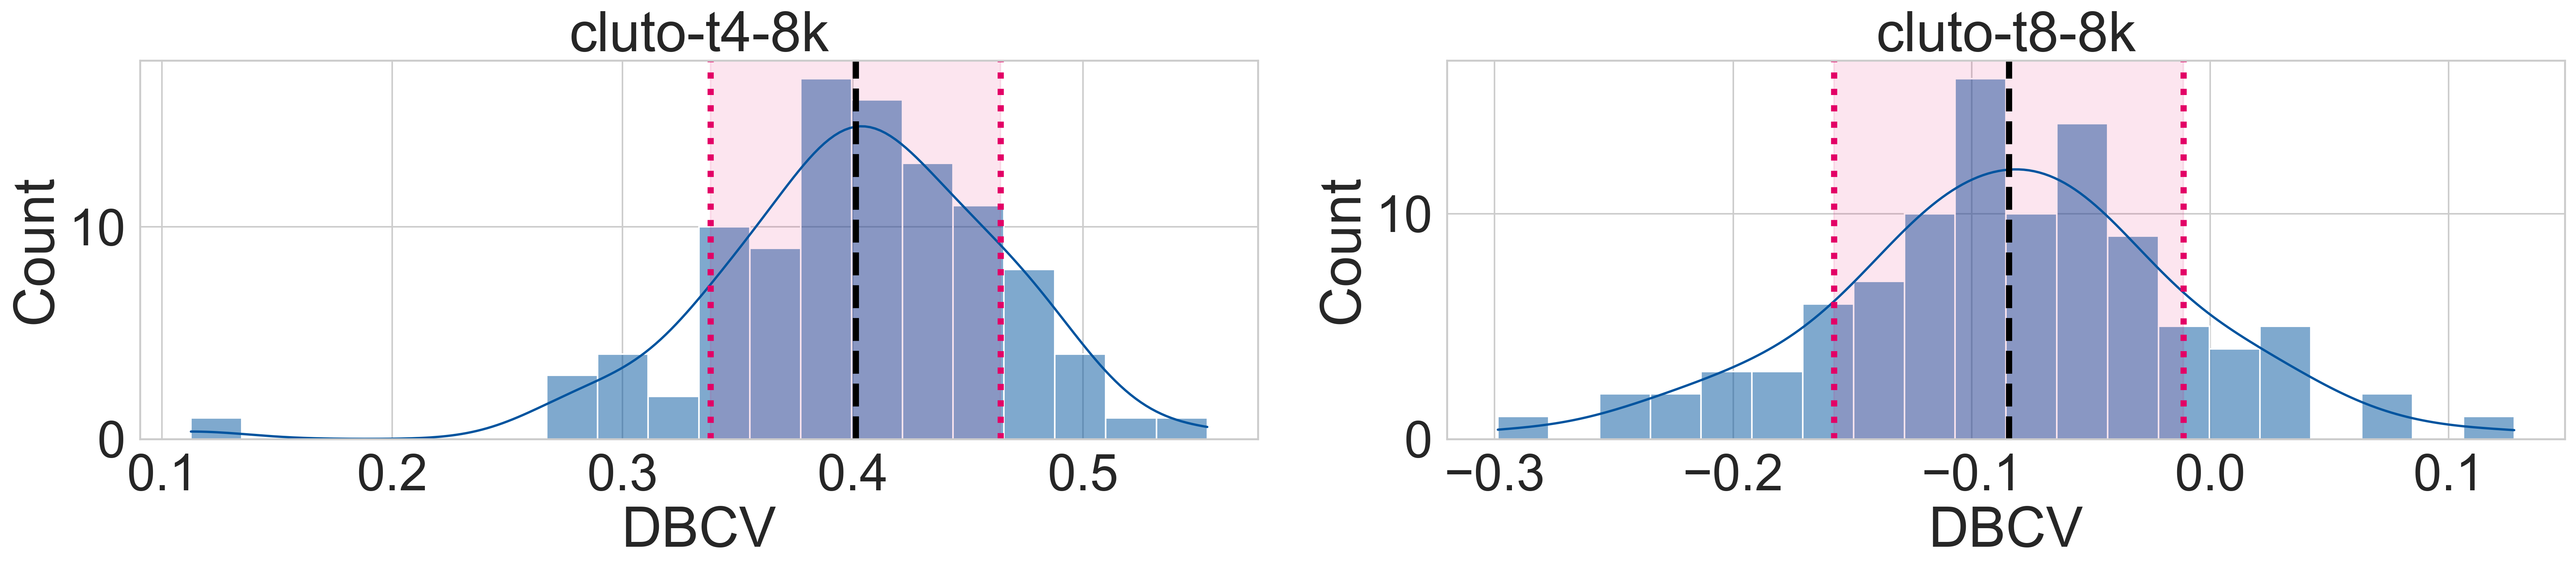

/var/folders/nc/bk5y8hg15dj22klbh0nsdc400000gn/T/ipykernel_86800/2876986620.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a, ax=ax, kde=True, color='#00549F')
/var/folders/nc/bk5y8hg15dj22klbh0nsdc400000gn/T/ipykernel_86800/2876986620.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a, 

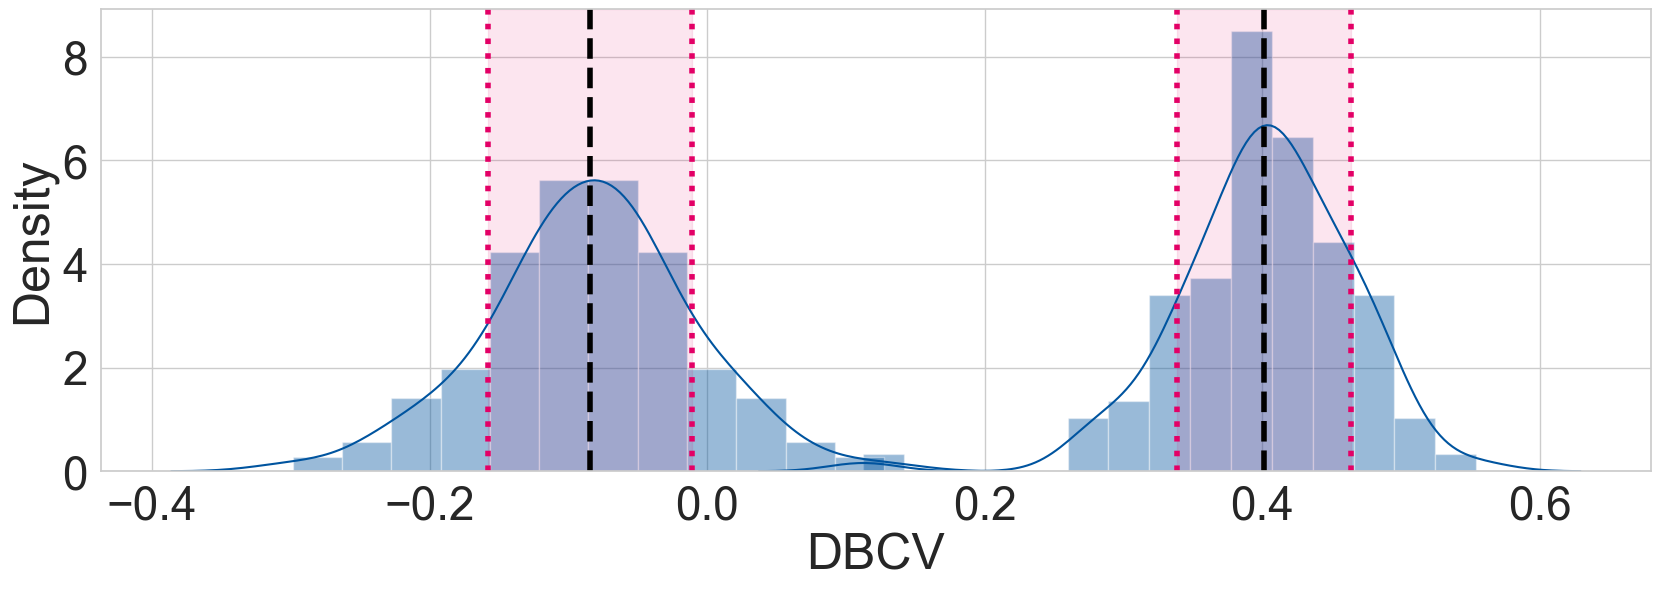

In [27]:
x = dbcv_cluto_8_4_std['DBCV']
y = dbcv_cluto_8_8_std['DBCV']

df = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'DBCV': x, 'Dataset': 'cluto-t4-8k'}),
    pd.DataFrame.from_dict({'DBCV': y, 'Dataset': 'cluto-t8-8k'})
])
# Create an array with the colors you want to use
colors = ["#57AB27","#00549F", "#0098A1","#006165",]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(figsize=(18,6))
sns.histplot(
    data=df, x='DBCV', hue='Dataset', ax=ax, kde=True, bins=60
)
mean = dbcv_cluto_8_8_std['DBCV'].mean()
std = dbcv_cluto_8_8_std['DBCV'].std()
ax.axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
ax.axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
ax.axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
ax.axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')

mean = dbcv_cluto_8_4_std['DBCV'].mean()
std = dbcv_cluto_8_4_std['DBCV'].std()
ax.axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
ax.axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
ax.axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
ax.axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')

sns.move_legend(ax, bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)

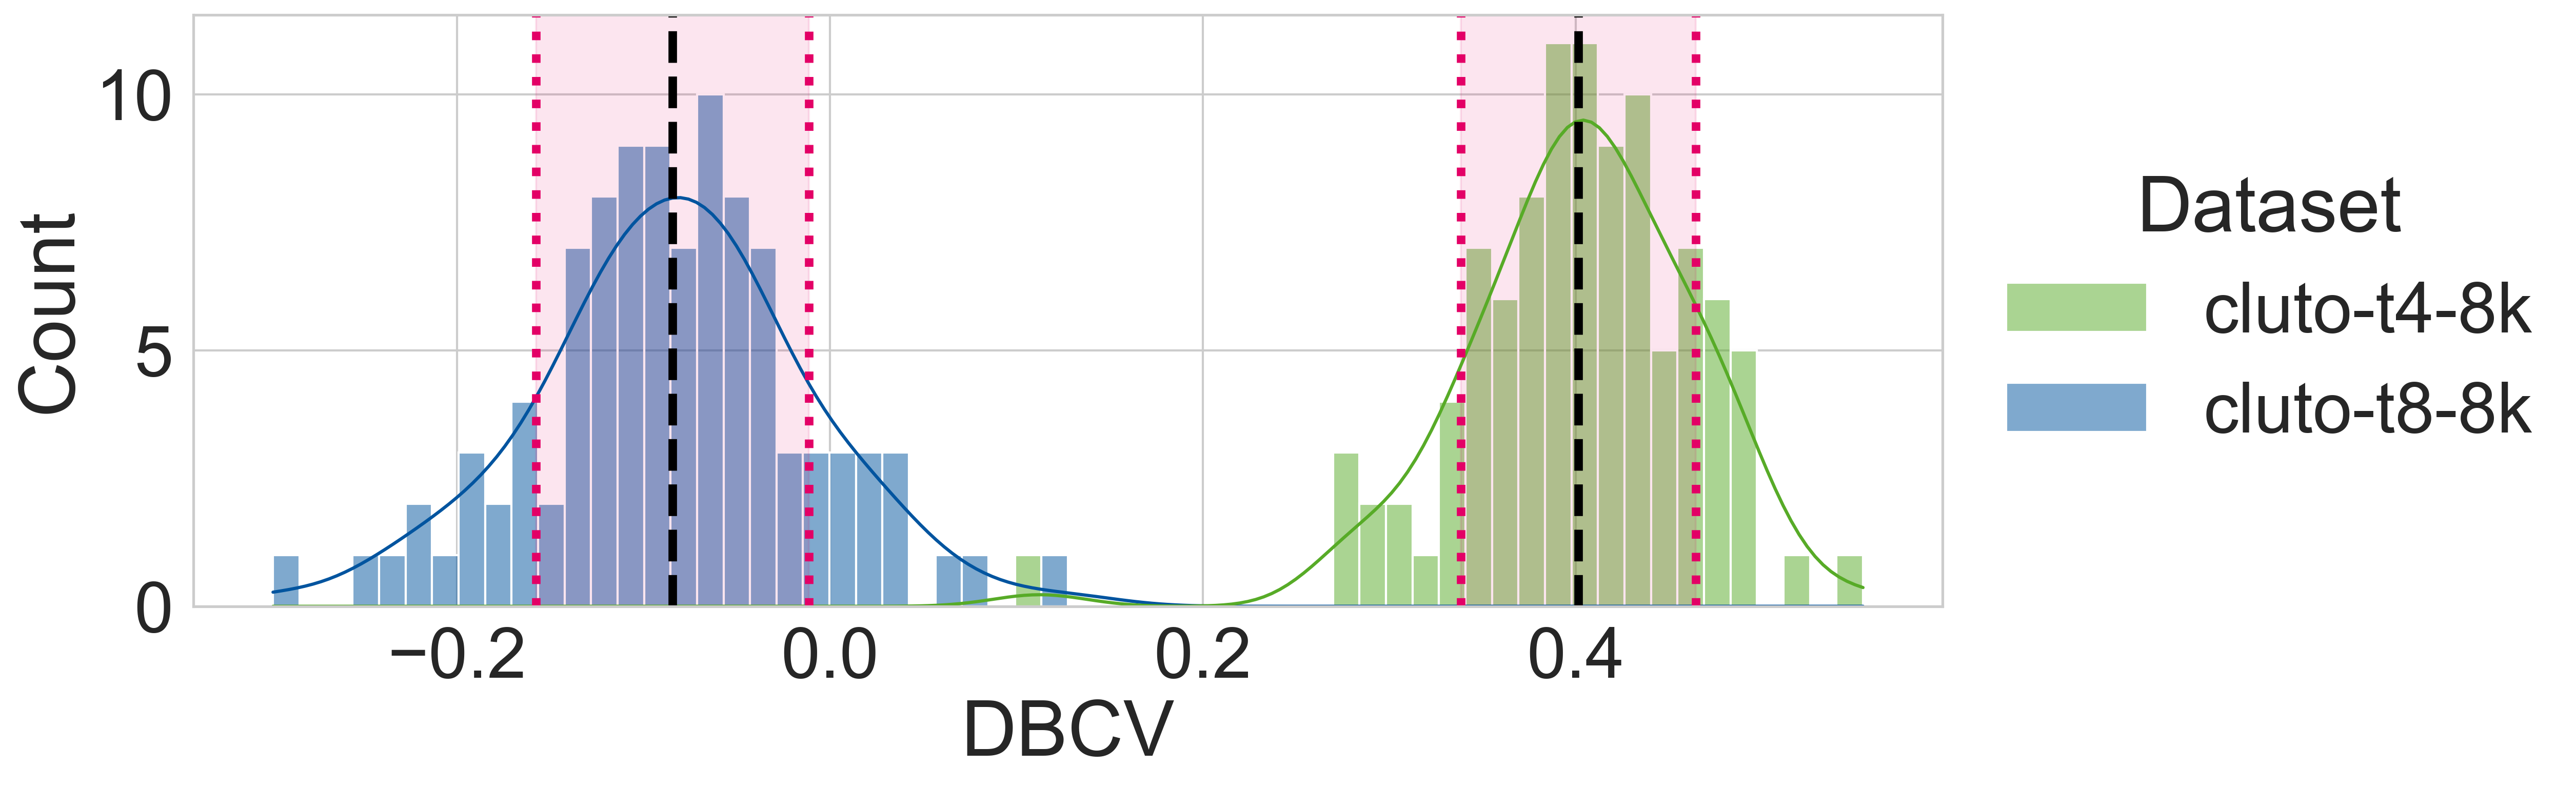

In [43]:

x = dbcv_cluto_8_4_std['DBCV']
y = dbcv_cluto_8_8_std['DBCV']

df = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'DBCV': x, 'Dataset': 'cluto-t4-8k'}),
    pd.DataFrame.from_dict({'DBCV': y, 'Dataset': 'cluto-t8-8k'})
])
# Create an array with the colors you want to use
colors = ["#57AB27","#00549F", "#0098A1","#006165",]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(figsize=(18,6))
sns.histplot(
    data=df, x='DBCV', hue='Dataset', ax=ax, kde=True, bins=60
)
mean = dbcv_cluto_8_8_std['DBCV'].mean()
std = dbcv_cluto_8_8_std['DBCV'].std()
ax.axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
ax.axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
ax.axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
ax.axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')

mean = dbcv_cluto_8_4_std['DBCV'].mean()
std = dbcv_cluto_8_4_std['DBCV'].std()
ax.axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
ax.axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
ax.axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
ax.axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')

sns.move_legend(ax, bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)
plt.tight_layout()
fig.set_dpi(300)

In [42]:
n = 1000
dbcv_list_cluto_4_8_std = run_multiple_shuffle_runs(n, cluto_df_4_8_std)
dbcv_list_cluto_8_8_std = run_multiple_shuffle_runs(n, cluto_df_8_8_std)

100%|██████████| 1000/1000 [13:20<00:00,  1.32it/s]


In [44]:
dbcv_cluto_8_4_std = pd.DataFrame(data = np.array(dbcv_list_cluto_4_8_std), columns = ['DBCV'])
dbcv_cluto_8_8_std = pd.DataFrame(data = np.array(dbcv_list_cluto_8_8_std), columns = ['DBCV'])

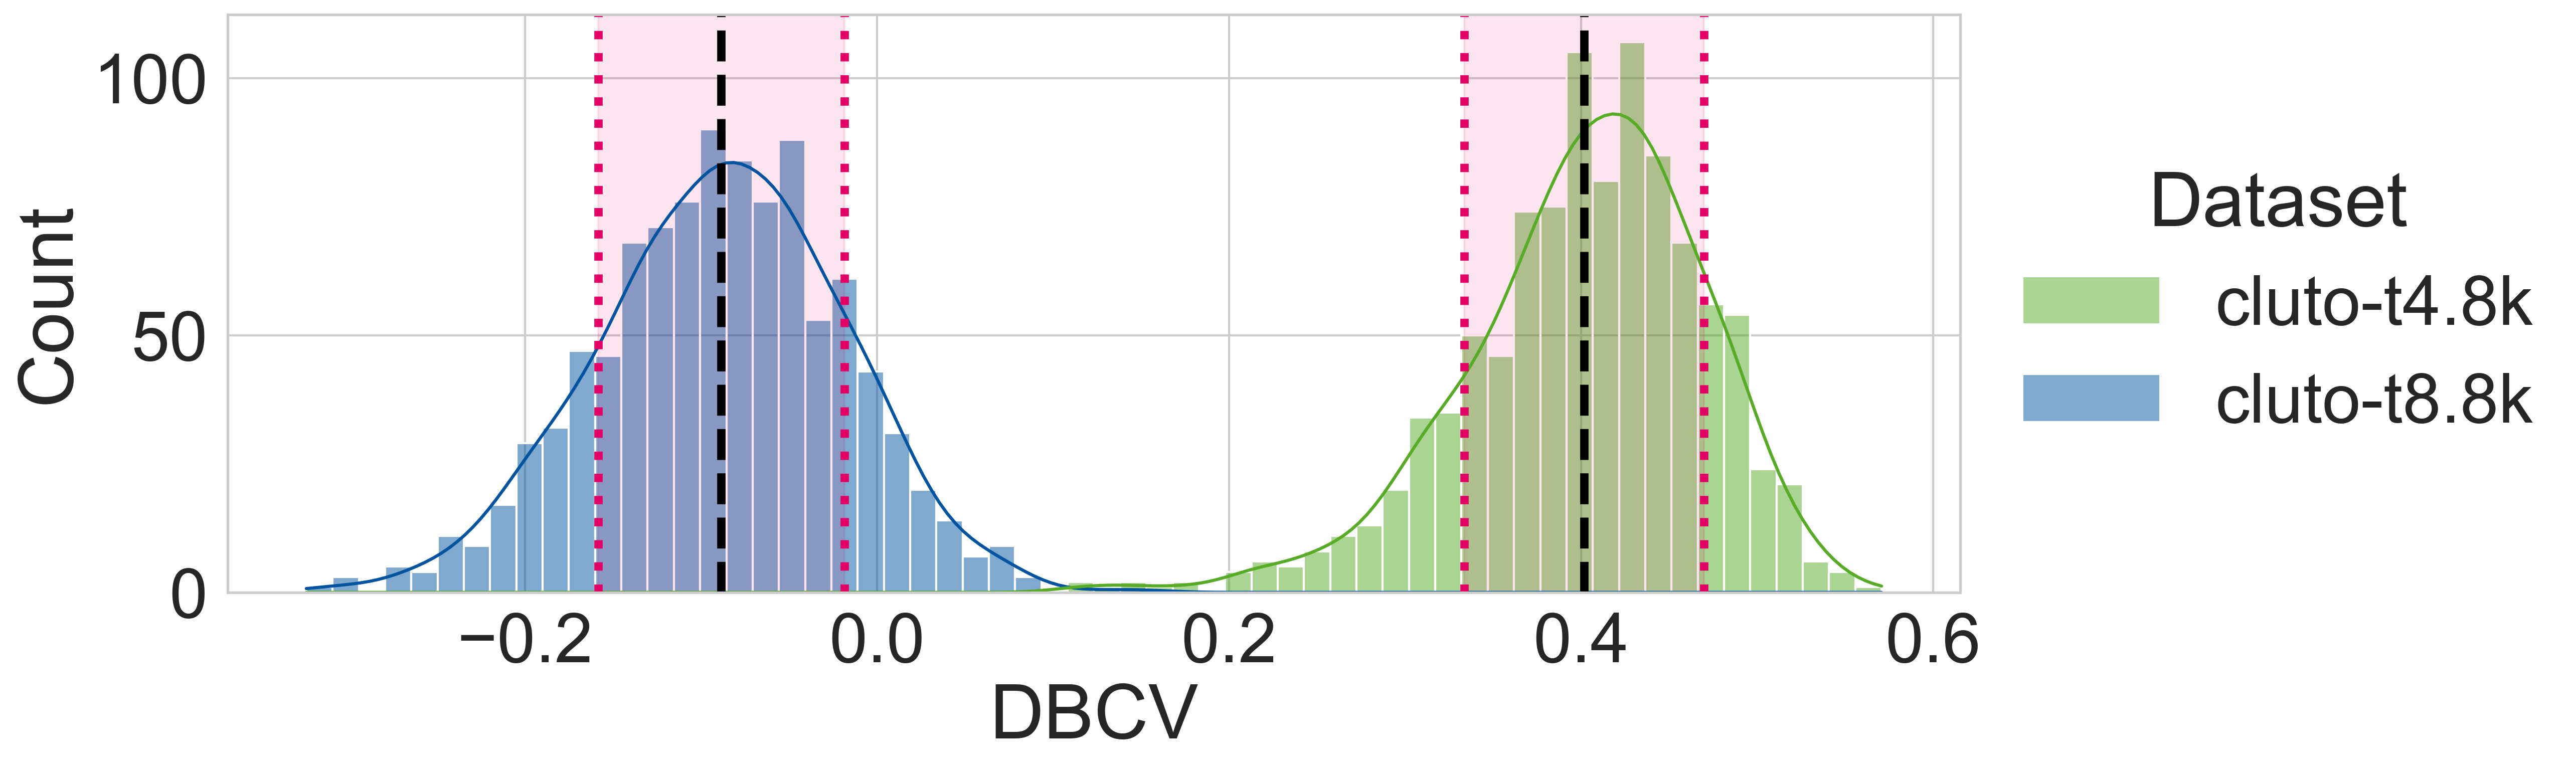

In [51]:
x = dbcv_cluto_8_4_std['DBCV']
y = dbcv_cluto_8_8_std['DBCV']

df = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'DBCV': x, 'Dataset': 'cluto-t4.8k'}),
    pd.DataFrame.from_dict({'DBCV': y, 'Dataset': 'cluto-t8.8k'})
])
# Create an array with the colors you want to use
colors = ["#57AB27","#00549F", "#0098A1","#006165",]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(figsize=(18,6))
sns.histplot(
    data=df, x='DBCV', hue='Dataset', ax=ax, kde=True, bins=60
)
mean = dbcv_cluto_8_8_std['DBCV'].mean()
std = dbcv_cluto_8_8_std['DBCV'].std()
ax.axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
ax.axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
ax.axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
ax.axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')

mean = dbcv_cluto_8_4_std['DBCV'].mean()
std = dbcv_cluto_8_4_std['DBCV'].std()
ax.axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
ax.axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
ax.axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
ax.axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')

sns.move_legend(ax, bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)
plt.tight_layout()
fig.set_dpi(300)
plt.savefig('DBCV.png', dpi=300)

In [12]:
#sns.set(font_scale=3)
#sns.set_style("whitegrid")
#fig, axs = plt.subplots(ncols=3, figsize=(24, 6))

#mean = dbcv_moons_0['DBCV'].mean()
#std = dbcv_moons_0['DBCV'].std() 
#sns.histplot(data=dbcv_moons_0, x="DBCV", kde=True,ax=axs[0],color='#00549F',bins=20)
#axs[0].axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
#axs[0].axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
#axs[0].axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
#axs[0].axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')
#axs[0].set_title("Two moons (0.0 noise)")



#sns.histplot(data=dbcv_moons_1, x="DBCV", kde=True,ax=axs[1],color='#00549F',bins=20)
#mean = dbcv_moons_1['DBCV'].mean()
#std = dbcv_moons_1['DBCV'].std()
#axs[1].axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
#axs[1].axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
#axs[1].axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
#axs[1].axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')
#axs[1].set_title("Two moons (0.1 noise)")
#axs[1].axvline(disco[1], color='k', linestyle='dashed', linewidth=2)
#sns.histplot(data=dbcv_moons_3, x="DBCV", kde=True,ax=axs[2],color='#00549F',bins=20)
#mean = dbcv_moons_3['DBCV'].mean()
#std = dbcv_moons_3['DBCV'].std()
#print(std*std)
#axs[2].axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
#axs[2].axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
#axs[2].axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
#axs[2].axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')
#axs[2].set_title("Two moons (0.2 noise)")
#axs[2].axvline(disco[2], color='k', linestyle='dashed', linewidth=2)
#plt.tight_layout()
#fig.set_dpi(300)

In [13]:
#sns.set(font_scale=3)
#sns.set_style("whitegrid")
#fig, axs = plt.subplots(ncols=2, figsize=(24, 6))

#mean = dbcv_cluto_8_4['DBCV'].mean()
#std = dbcv_cluto_8_4['DBCV'].std() 
#sns.histplot(data=dbcv_cluto_8_4, x="DBCV", kde=True,ax=axs[0],color='#00549F',bins=20)
#axs[0].axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
#axs[0].axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
#axs[0].axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
#axs[0].axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')
#axs[0].set_title("cluto 4 8")



#sns.histplot(data=dbcv_cluto_8_8, x="DBCV", kde=True,ax=axs[1],color='#00549F',bins=20)
#mean = dbcv_cluto_8_8['DBCV'].mean()
#std = dbcv_cluto_8_8['DBCV'].std()
#axs[1].axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
#axs[1].axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
#axs[1].axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
#axs[1].axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')
#axs[1].set_title("cluto 8 8")
#axs[1].axvline(disco[1], color='k', linestyle='dashed', linewidth=2)
#plt.tight_layout()
#fig.set_dpi(300)

In [14]:
#sns.set(font_scale=3)
#sns.set_style("whitegrid")
#fig, axs = plt.subplots(ncols=2, figsize=(24, 6))

#mean = dbcv_cluto_8_4_std['DBCV'].mean()
#std = dbcv_cluto_8_4_std['DBCV'].std() 
#sns.histplot(data=dbcv_cluto_8_4_std, x="DBCV", kde=True,ax=axs[0],color='#00549F',bins=20)
#axs[0].axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
#axs[0].axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
#axs[0].axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
#axs[0].axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')
#axs[0].set_title("cluto 4 8 std")



#sns.histplot(data=dbcv_cluto_8_8_std, x="DBCV", kde=True,ax=axs[1],color='#00549F',bins=20)
#mean = dbcv_cluto_8_8_std['DBCV'].mean()
#std = dbcv_cluto_8_8_std['DBCV'].std()
#axs[1].axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
#axs[1].axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
#axs[1].axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
#axs[1].axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')
#axs[1].set_title("cluto 8 8 std")
#axs[1].axvline(disco[1], color='k', linestyle='dashed', linewidth=2)
#plt.tight_layout()
#fig.set_dpi(300)

In [15]:
#sns.set(font_scale=3)
#sns.set_style("whitegrid")
#fig, axs = plt.subplots(ncols=2, figsize=(24, 6))

#mean = dbcv_cluto_8_4_n['DBCV'].mean()
#std = dbcv_cluto_8_4_n['DBCV'].std() 
#sns.histplot(data=dbcv_cluto_8_4_n, x="DBCV", kde=True,ax=axs[0],color='#00549F',bins=20)
#axs[0].axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
#axs[0].axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
#axs[0].axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
#axs[0].axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')
#axs[0].set_title("cluto 4 8 non squared")



#sns.histplot(data=dbcv_cluto_8_8_n, x="DBCV", kde=True,ax=axs[1],color='#00549F',bins=20)
#mean = dbcv_cluto_8_8_n['DBCV'].mean()
#std = dbcv_cluto_8_8_n['DBCV'].std()
#axs[1].axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
#axs[1].axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
#axs[1].axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
#axs[1].axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')
#axs[1].set_title("cluto 8 8 non squared")
#axs[1].axvline(disco[1], color='k', linestyle='dashed', linewidth=2)
#plt.tight_layout()
#fig.set_dpi(300)

In [16]:
#sns.set(font_scale=3)
#sns.set_style("whitegrid")
#fig, axs = plt.subplots(ncols=2, figsize=(24, 6))

#mean = dbcv_cluto_8_4_std_n['DBCV'].mean()
#std = dbcv_cluto_8_4_std_n['DBCV'].std() 
#sns.histplot(data=dbcv_cluto_8_4_std_n, x="DBCV", kde=True,ax=axs[0],color='#00549F',bins=20)
#axs[0].axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
#axs[0].axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
#axs[0].axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
#axs[0].axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')
#axs[0].set_title("cluto 4 8 std non squared")



#sns.histplot(data=dbcv_cluto_8_8_std_n, x="DBCV", kde=True,ax=axs[1],color='#00549F',bins=20)
#mean = dbcv_cluto_8_8_std_n['DBCV'].mean()
#std = dbcv_cluto_8_8_std_n['DBCV'].std()
#axs[1].axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
#axs[1].axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
#axs[1].axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
#axs[1].axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')
#axs[1].set_title("cluto 8 8 std non squared")
#axs[1].axvline(disco[1], color='k', linestyle='dashed', linewidth=2)
#plt.tight_layout()
#fig.set_dpi(300)

In [17]:
#sns.set(font_scale=3)
# sns.set_style("whitegrid")
# fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(24, 24))
# 
# mean = dbcv_cluto_8_4['DBCV'].mean()
# std = dbcv_cluto_8_4['DBCV'].std() 
# sns.histplot(data=dbcv_cluto_8_4, x="DBCV", kde=True,ax=axs[0][0],color='#00549F',bins=20)
# axs[0][0].axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
# axs[0][0].axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
# axs[0][0].axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
# axs[0][0].axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')
# axs[0][0].set_title("cluto 4 8 ")
# 
# 
# 
# sns.histplot(data=dbcv_cluto_8_8, x="DBCV", kde=True,ax=axs[0][1],color='#00549F',bins=20)
# mean = dbcv_cluto_8_8['DBCV'].mean()
# std = dbcv_cluto_8_8['DBCV'].std()
# axs[0][1].axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
# axs[0][1].axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
# axs[0][1].axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
# axs[0][1].axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')
# axs[0][1].set_title("cluto 8 8 ")
# 
# mean = dbcv_cluto_8_4_n['DBCV'].mean()
# std = dbcv_cluto_8_4_n['DBCV'].std() 
# sns.histplot(data=dbcv_cluto_8_4_n, x="DBCV", kde=True,ax=axs[1][0],color='#00549F',bins=20)
# axs[1][0].axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
# axs[1][0].axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
# axs[1][0].axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
# axs[1][0].axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')
# axs[1][0].set_title("cluto 4 8 non squared")
# 
# 
# 
# sns.histplot(data=dbcv_cluto_8_8_n, x="DBCV", kde=True,ax=axs[1][1],color='#00549F',bins=20)
# mean = dbcv_cluto_8_8_n['DBCV'].mean()
# std = dbcv_cluto_8_8_n['DBCV'].std()
# axs[1][1].axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
# axs[1][1].axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
# axs[1][1].axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
# axs[1][1].axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')
# axs[1][1].set_title("cluto 8 8 non squared")
# 
# mean = dbcv_cluto_8_4_std['DBCV'].mean()
# std = dbcv_cluto_8_4_std['DBCV'].std() 
# sns.histplot(data=dbcv_cluto_8_4_std, x="DBCV", kde=True,ax=axs[2][0],color='#00549F',bins=20)
# axs[2][0].axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
# axs[2][0].axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
# axs[2][0].axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
# axs[2][0].axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')
# axs[2][0].set_title("cluto 4 8 std")
# 
# 
# 
# sns.histplot(data=dbcv_cluto_8_8_std, x="DBCV", kde=True,ax=axs[2][1],color='#00549F',bins=20)
# mean = dbcv_cluto_8_8_std['DBCV'].mean()
# std = dbcv_cluto_8_8_std['DBCV'].std()
# axs[2][1].axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
# axs[2][1].axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
# axs[2][1].axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
# axs[2][1].axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')
# axs[2][1].set_title("cluto 8 8 std ")
# 
# mean = dbcv_cluto_8_4_std_n['DBCV'].mean()
# std = dbcv_cluto_8_4_std_n['DBCV'].std() 
# sns.histplot(data=dbcv_cluto_8_4_std_n, x="DBCV", kde=True,ax=axs[3][0],color='#00549F',bins=20)
# axs[3][0].axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
# axs[3][0].axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
# axs[3][0].axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
# axs[3][0].axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')
# axs[3][0].set_title("cluto 4 8 std non squared")
# 
# 
# 
# sns.histplot(data=dbcv_cluto_8_8_std_n, x="DBCV", kde=True,ax=axs[3][1],color='#00549F',bins=20)
# mean = dbcv_cluto_8_8_std_n['DBCV'].mean()
# std = dbcv_cluto_8_8_std_n['DBCV'].std()
# axs[3][1].axvline(mean, color='#000000', linestyle='dashed', linewidth=4)
# axs[3][1].axvline(mean-std, color='#E30066', linestyle='dotted', linewidth=4)
# axs[3][1].axvline(mean+std, color='#E30066', linestyle='dotted', linewidth=4)
# axs[3][1].axvspan(mean-std, mean+std, alpha=0.1, color='#E30066')
# axs[3][1].set_title("cluto 8 8 std non squared")
# #axs[1].axvline(disco[1], color='k', linestyle='dashed', linewidth=2)
# plt.tight_layout()
# fig.set_dpi(300)

[0.3577570530782345, 0.4152466284441479, 0.2826478645051833, 0.41352151654425523, 0.3938115374185253, 0.4541399394068734, 0.40203544700821764, 0.3313369112439549, 0.5539819472929413, 0.4368508859992238, 0.37771169696522267, 0.47176183276018413, 0.4200273417035099, 0.4512097234448126, 0.4006028342255217, 0.39430290158076076, 0.4916393350457168, 0.432967835957103, 0.3447283716301492, 0.4604058348583289, 0.42858078879196204, 0.2739595887352279, 0.4125221150037806, 0.3797600527291462, 0.34071766168130097, 0.43023198834190823, 0.406776339581642, 0.4307352560144024, 0.4241874683392782, 0.39065398065633433, 0.3648603860418095, 0.34996513619526537, 0.48011539564556927, 0.40363322460905754, 0.33543883497786436, 0.3544135876505247, 0.4485078662357938, 0.4602561089957957, 0.42254033785089495, 0.4538324867364957, 0.3800749064263272, 0.39959505956022895, 0.3415755548021904, 0.390451460320176, 0.4697816279356289, 0.4154449625517757, 0.4311230388772884, 0.27232336142374525, 0.3895572653558531, 0.3936

<Axes: xlabel='DBCV', ylabel='Count'>

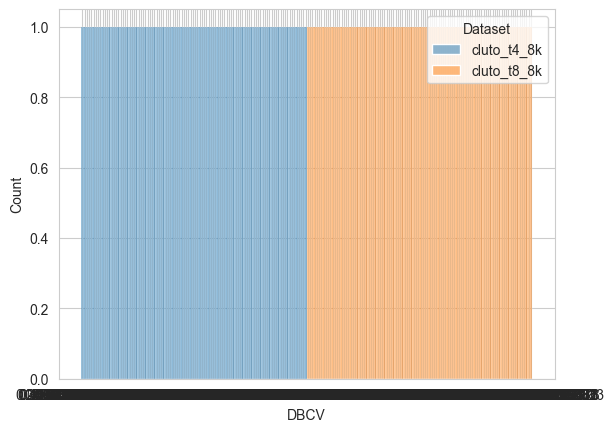

In [18]:
print(dbcv_list_cluto_4_8_std)
names = np.array(['cluto_t4_8k']*len(dbcv_list_cluto_4_8_std)+[ 'cluto_t8_8k']*len(dbcv_list_cluto_4_8_std))
names = np.expand_dims(names, axis=1)
values = np.array(dbcv_list_cluto_4_8_std + dbcv_list_cluto_8_8_std)

values = np.expand_dims(values, axis=1)
data = np.concatenate((values,names), axis=1)
dbcv_cluto = pd.DataFrame(data = data, columns = ['DBCV','Dataset'])
print(dbcv_cluto)
sns.histplot(data=dbcv_cluto, x="DBCV", hue="Dataset")